In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder , OneHotEncoder , StandardScaler

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score , f1_score , precision_score , recall_score , roc_curve , roc_auc_score , precision_recall_curve , average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
df = pd.read_csv('/Data/cleaned_Travel.csv')

df.head()

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,Designation,MonthlyIncome,TotalPersonVisting
0,1,41,Self Enquiry,3,6,Salaried,Female,3,Deluxe,3,Unmarried,1,1,2,1,Manager,20993,3
1,0,49,Company Invited,1,14,Salaried,Male,4,Deluxe,4,Divorced,2,0,3,1,Manager,20130,5
2,1,37,Self Enquiry,1,8,Free Lancer,Male,4,Basic,3,Unmarried,7,1,3,0,Executive,17090,3
3,0,33,Company Invited,1,9,Salaried,Female,3,Basic,3,Divorced,2,1,5,1,Executive,17909,3
4,0,36,Self Enquiry,1,8,Small Business,Male,3,Basic,4,Divorced,1,0,5,1,Executive,18468,2


<!-- ---- -->

TRAIN TEST SPLIT

In [3]:
X = df.drop('ProdTaken', axis=1)

y = df['ProdTaken']

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3666, 17), (1222, 17), (3666,), (1222,))

In [5]:
X_train.dtypes

Age                        int64
TypeofContact             object
CityTier                   int64
DurationOfPitch            int64
Occupation                object
Gender                    object
NumberOfFollowups          int64
ProductPitched            object
PreferredPropertyStar      int64
MaritalStatus             object
NumberOfTrips              int64
Passport                   int64
PitchSatisfactionScore     int64
OwnCar                     int64
Designation               object
MonthlyIncome              int64
TotalPersonVisting         int64
dtype: object

In [6]:
cat_col = X_train.select_dtypes(include = 'object').columns

num_col = X_train.select_dtypes(exclude = ['object']).columns

numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(drop = 'first')

preprocessor = ColumnTransformer(
    transformers = [
        ('OneHotEncoder', categorical_transformer, cat_col) , 
        ('standardScaler' , numeric_transformer, num_col)
    ], remainder='passthrough'
)
preprocessor

X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test)




In [7]:
X_train.shape

(3666, 26)

In [8]:
pd.DataFrame(X_train , columns = preprocessor.get_feature_names_out()).head()

,OneHotEncoder__TypeofContact_Self Enquiry,OneHotEncoder__Occupation_Large Business,OneHotEncoder__Occupation_Salaried,OneHotEncoder__Occupation_Small Business,OneHotEncoder__Gender_Male,OneHotEncoder__ProductPitched_Deluxe,OneHotEncoder__ProductPitched_King,OneHotEncoder__ProductPitched_Standard,OneHotEncoder__ProductPitched_Super Deluxe,OneHotEncoder__MaritalStatus_Married,...,standardScaler__CityTier,standardScaler__DurationOfPitch,standardScaler__NumberOfFollowups,standardScaler__PreferredPropertyStar,standardScaler__NumberOfTrips,standardScaler__Passport,standardScaler__PitchSatisfactionScore,standardScaler__OwnCar,standardScaler__MonthlyIncome,standardScaler__TotalPersonVisting
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.469855,-0.550683,1.293557,-0.728047,-0.118693,1.560705,-0.787818,-1.283328,-0.069384,0.650658
1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.469855,-0.674612,1.293557,-0.728047,-0.118693,1.560705,0.675273,-1.283328,-0.412435,-0.058834
2,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,-0.712603,-0.550683,-1.714169,0.525603,-0.118693,1.560705,0.675273,0.779224,0.245334,-0.058834
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.712603,0.068962,-1.714169,-0.728047,0.450101,1.560705,-0.056273,-1.283328,-1.201225,-0.768326
4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.469855,1.184323,-2.716744,-0.728047,-1.256281,1.560705,-1.519363,-1.283328,-0.613436,-0.768326


In [9]:
#  DEFINING SCALE POS WEIGHT FOR XGBOOST. TO HANDLE IMBALANCED DATA

scale_pos = y_train.value_counts()[0] / y_train.value_counts()[1]

print(scale_pos)

4.3130434782608695


In [10]:
# Define the models

models = {
    'XGBClassifier': XGBClassifier(scale_pos_weight = scale_pos , random_state = 42),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state = 42),
    'RandomForestClassifier': RandomForestClassifier(class_weight='balanced' , random_state = 42)
}

for name , clf in models.items() :

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print(f"Model {name} trained successfully." , '\n')
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_pred)}")

    print("\n" + "="*50 + "\n")
    

Model XGBClassifier trained successfully. 

Accuracy: 0.9345335515548282
F1 Score: 0.8230088495575221
Precision: 0.8378378378378378
Recall: 0.808695652173913
ROC AUC: 0.886202664796634


Model GradientBoostingClassifier trained successfully. 

Accuracy: 0.855973813420622
F1 Score: 0.49714285714285716
Precision: 0.725
Recall: 0.3782608695652174
ROC AUC: 0.6724973702664797


Model RandomForestClassifier trained successfully. 

Accuracy: 0.9173486088379705
F1 Score: 0.7362924281984334
Precision: 0.9215686274509803
Recall: 0.6130434782608696
ROC AUC: 0.8004733520336607




HYPERPARAMTER TUNING THE XGBOOST MODEL

In [11]:
param_grid = {
    
    'n_estimators': [50, 100, 200],

    'max_depth': [3, 5, 7],

    'learning_rate': [0.1 , 0.5 , 1],

    'subsample': [0.8, 0.9, 1.0],

    'colsample_bytree': [0.8 , 1.0]
}

random_search = RandomizedSearchCV(models['XGBClassifier'], param_distributions=param_grid , cv = 5 , n_iter = 100 , scoring = 'roc_auc' , n_jobs = -1)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.1, 0.5, 1],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.8, 0.9, 1.0]},
                   scoring='roc_auc')

In [12]:
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.8}


In [13]:
random_search.best_score_

np.float64(0.9388249271112006)

In [14]:
y_pred_best = random_search.predict(X_test)

print(f"Best Model Accuracy: {accuracy_score(y_test, y_pred_best)}")
print(f"Best Model F1 Score: {f1_score(y_test, y_pred_best)}")
print(f"Best Model Precision: {precision_score(y_test, y_pred_best)}")
print(f"Best Model Recall: {recall_score(y_test, y_pred_best)}")

Best Model Accuracy: 0.9427168576104746
Best Model F1 Score: 0.8423423423423423
Best Model Precision: 0.8738317757009346
Best Model Recall: 0.8130434782608695


In [15]:
y_prob_best = random_search.predict_proba(X_test)[:, 1]

print(f"Best Model ROC AUC: {roc_auc_score(y_test, y_prob_best):.4f}")


Best Model ROC AUC: 0.9622


In [16]:
y_prob = random_search.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

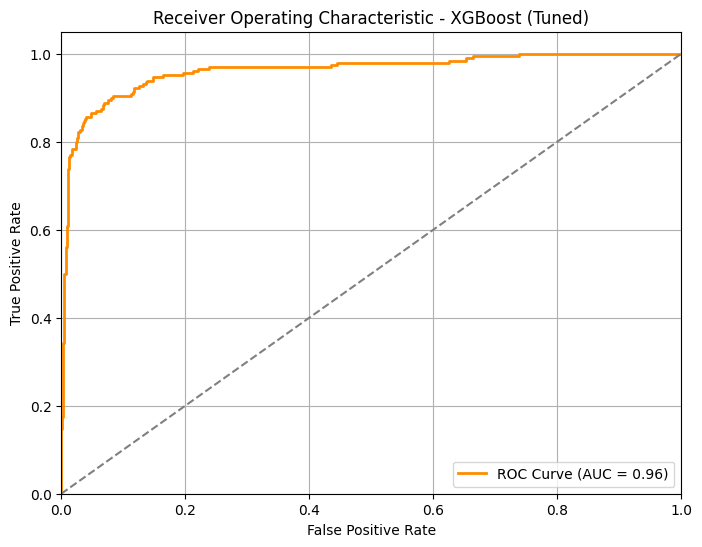

In [17]:
# Plot the ROC curve

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')

# Diagonal line for random classifier
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost (Tuned)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

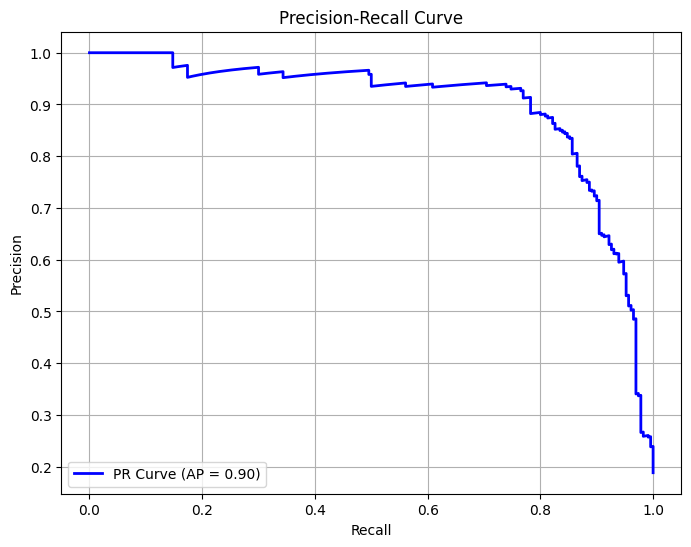

In [23]:
# 2️⃣ Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# 3️⃣ Compute the average precision score (area under PR curve)
avg_precision = average_precision_score(y_test, y_prob)

# 4️⃣ Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()





In [18]:
import pickle

# Save the best model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(random_search.best_estimator_, f)

# Save the preprocessor
with open('preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)